# Iron Ore Dataset

In this notebook we are going to use the dataset **Iron Ore** explored in week **05-simple-predictions** to illustrate the machine learning techniques:
 - K-nearest neighbors (K-NN)
 - Random Forest
 - Support Vector Machines:
     - Linear Kernel
     - Radial Basis Function (RBF) Kernel
     - Polynomial Kernel
     
As this dataset is not for classification, we borrow from week **05-simple-predictions** the code below to transform the problem into a classification problem:

```python
# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pandas.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, 
```

In order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., plot_decision_boundary). We are not going to discuss the implementation aspects of these functions as it is not the scope, but you can to explore and read the content of the functions later on.

Summary:
 - [Data Processing](#data_processing)
 - [Splitting the Data into Train and Test Sets](#split)
 - [Data Normalisation](#normalisation)
 - [Building the Classifiers](#models)
     - [K-nearest neighbors (K-NN)](#knn)
     - [Random Forest](#rdf)
     - [Support Vector Machines](#svm)
  
  
__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

## Data Processing
<a id=data_processing></a>

In [1]:
# Standard libraries
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # plot nicely =)

# Auxiliar functions
from utils import *

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline

We are going to use [Pandas](https://pandas.pydata.org/) for the data processing. The function  [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) is going to be used to read the csv file.

In [2]:
# reading dataset
df = pd.read_csv('../data/iron_ore_study.csv')
df.head()

,FE,SIO2,AL2O3,P
0,58.33,1.95,2.20,0.07
1,57.53,2.45,2.62,0.08
2,57.05,2.94,3.37,0.12
3,56.43,2.95,2.91,0.09
4,57.70,2.89,2.43,0.08


Here we transform this dataset into a **classification task** using the strategy adopted in week **05-simple-predictions**.

In [3]:
# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pd.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

df.tail()

,FE,SIO2,AL2O3,P,is_ore
3495,63.14,2.09,1.26,0.05,True
3496,61.56,2.69,1.38,0.05,True
3497,60.33,2.89,1.66,0.05,True
3498,58.30,4.07,1.24,0.03,False
3499,61.00,3.80,1.24,0.03,True


The column **is_ore** was created to label each sample (row). Next, let's analyse the distribution of the labels.

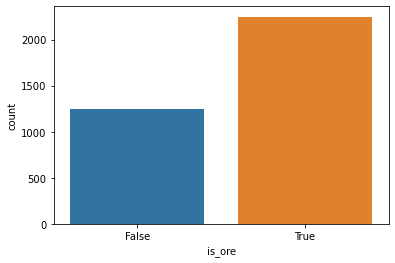

In [4]:
sns.countplot(x='is_ore', data=df);

Now, we will:
1. store the labels in the variable *y* (ie, the column 'is_ore' of *df*).
2. remove the labels from the original dataframe *df*. 

In [5]:
y = df["is_ore"].copy(deep=True) # set the variable 'y' to store the labels

# removing is_ore from the dataframe 
list_lbl = ['is_ore'] # list with columns to drop. In that case, it is only one. 
df = df.drop(list_lbl,axis = 1 )
df.head()

# we are going to use the function unique, from numpy, to count the number of 
# unique labels in the dataset. This returns the sorted unique elements of an array and 
# by setting the parameter 'return_count' will return the number of occurencies
# of each unique label
unique, counts = np.unique(y, return_counts=True)

print('is ore == {}:'.format(unique[0]), counts[0])
print('is ore == {}:'.format(unique[1]), counts[1])
print('Proportion:', round(counts[0] / counts[1], 2), ': 1')

is ore == False: 1252
is ore == True: 2248
Proportion: 0.56 : 1


Of course, the distribution of labels in *y* is the same as in *df* (as plotted above). 

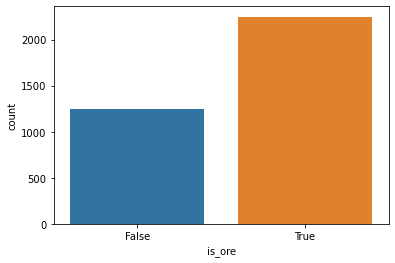

In [6]:
sns.countplot(x=y);

### Splitting the Data into Train and Test Sets
<a id=split></a>

First, we need to split the dataset into train and test sets.

In [7]:
from sklearn.model_selection import train_test_split #split arrays or matrices into random train and test subsets

# split data train 70% and test 30%. You can try other splits here.
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, 
                                                    random_state=42)

# The function 'describe' in pandas summarizes the central tendency, dispersion and 
# shape of a dataset’s distribution, excluding NaN values.
x_train.describe()

,FE,SIO2,AL2O3,P
count,2450.000000,2450.000000,2450.000000,2450.000000
mean,60.625796,2.735910,1.392286,0.058498
std,1.421251,0.898308,0.400679,0.019783
min,51.050000,1.020000,0.450000,0.010000
25%,59.732500,2.160000,1.140000,0.050000
50%,60.720000,2.540000,1.330000,0.060000
75%,61.590000,3.067500,1.570000,0.070000
max,64.650000,12.120000,3.970000,0.220000


---
**Your turn!**

1. Plot the distribution of the *y* variables, for both the train and test sets.
2. Compare them. Can you see the expected result given the choice *test_size=0.3*? 
3. Can you plot the distribution (of True and False) for the *x* variables by simply using sns.countplot() command? 
---

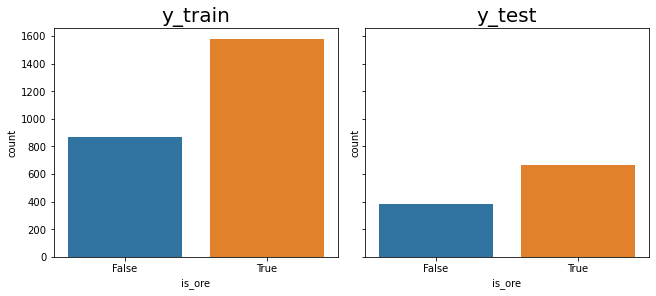

In [8]:
# Answer
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True, constrained_layout=True)

i = 0
axes[i].set_title("y_train", fontsize=20)
sns.countplot(x=y_train, ax=axes[i])

i += 1
axes[i].set_title("y_test", fontsize=20)
sns.countplot(x=y_test, ax=axes[i]);

### Data Normalisation
<a id=normalisation></a>

As we can see in the table above (describe()), the *mean*, the *min* and *max* values are different between all the features. In order to remove this amplitude variation we are going to **standardize** all the features (ie, zero mean and unity variance).

In [9]:
from sklearn.preprocessing import StandardScaler 

#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(x_train) # not considering the label is_ore; using the training data set!

x_train_scaled = scaler.transform(x_train)

x_test_scaled = scaler.transform(x_test)

---
**For you!** 

1. Note that we trained the *scaler* using the **train** dataset not the **test** dataset in the line *scaler.fit(x_train)*. Why?
2. Are the new variables Pandas DataFrames? If not, what are they?
---

In [10]:
# Summarizing the central tendency, dispersion and 
# shape of a dataset’s distribution.

aux = pd.DataFrame(x_train_scaled) # building a dataframe (just for convenience)
aux.columns = df.columns.tolist()  # including names for the columns
aux.describe()

,FE,SIO2,AL2O3,P
count,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03
mean,6.416998e-15,1.116567e-16,-1.624098e-16,-5.481330e-16
std,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00
min,-6.738957e+00,-1.910547e+00,-2.352200e+00,-2.451979e+00
25%,-6.286561e-01,-6.412361e-01,-6.297734e-01,-4.296431e-01
50%,6.629603e-02,-2.181324e-01,-1.554820e-01,7.594076e-02
75%,6.785576e-01,3.692023e-01,4.436229e-01,5.815246e-01
max,2.832029e+00,1.044853e+01,6.434672e+00,8.165283e+00


---
**For you!**
1. Compare, with a visualisation, the original data with their scaled versions. 

**Answer**

Here we provide (one of the possible answers) for the FE (iron) data. 

There is a pitfall here. If you just plot like this:

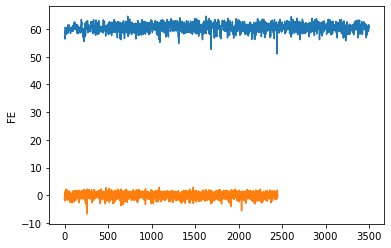

In [11]:
variable = "FE"

sns.lineplot(data=x_train[variable])
sns.lineplot(data=aux[variable]);

it seems that both data sets have different lengths!!! Let's double check that:

In [12]:
print(x_train.shape)
print(x_train_scaled.shape)

(2450, 4)
(2450, 4)


No, they have the same length (as it should be!). 

Seabor is using the "indexes" of the Pandas DataFrames in the horizontal (x) axis! From the possible solutions, the easyest one is to extract only the numerical values that we want to plot as the vertical (y) varibles by using *.values*:

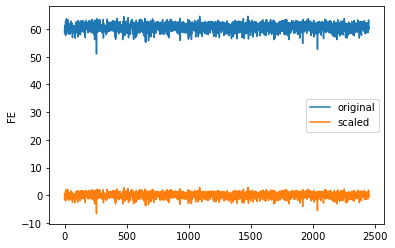

In [13]:
sns.lineplot(data=x_train[variable].values, label="original")
sns.lineplot(data=aux[variable].values, label="scaled")

plt.ylabel(variable); # data is not a Pandas DF anymore, so we manually provide the y-axis label here

---

## Building the Classifiers
<a id=models></a>

So far, we just preprocessed the dataset. Now, we are going to build the following classifiers:
 - [K-Nearest Neighbors (K-NN)](#knn)
 - [Random Forest](#rdf)
 - [Support Vector Machines](#svm)
     - [Linear Kernel](#linear)
     - [Radial Basis Function Kernel](#rbf)
     - [Polynomial Kernel](#poly)

### K-Nearest Neighbors (K-NN)
<a id=knn></a>

In short, a new instance is classified in this algorithm by a majority vote according its neighbors. The instance is assigned to the most common class among its *K* nearest neighbors.

<img src="imgs/knn.png" alt="Drawing" style="width: 300px;"/>


In [14]:
#from sklearn.neighbors.classification import KNeighborsClassifier #Classifier implementing the k-nearest neighbors vote.
from sklearn.neighbors import KNeighborsClassifier # as for version 0.22

clf_knn = KNeighborsClassifier(n_neighbors=3) # considering k=3    

clf_knn.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

The **decision boundary** illustrates how the model classifies the *samples*. To plot it, we are going to use the function *plot_decision_boundary* implemented in our auxiliar library *utils.py* (feel free to review the code for clarifications). The colormap indicates the probability that a sample belongs to class 1.

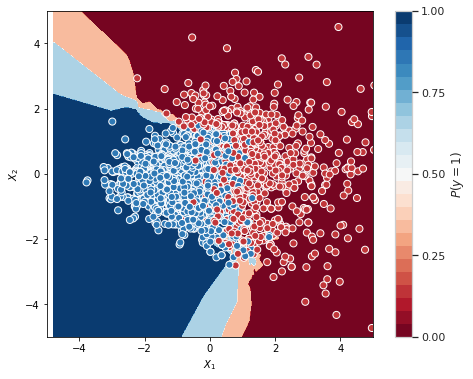

In [15]:
# plot_decision_boundary receives the training set (x_train_scaled), the labels (y_train) and
# the classifier (clf_knn) and plots the decision bounbary by projecting the data into 2 dimensions using 
# PCA (Principal Component Analysis)
plot_decision_boundary(x_train=x_train_scaled, 
                       y_train=y_train, 
                       estimator=clf_knn)

In order to evaluate the model, we are going to visualise the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and compute its **accuracy**. 

Accuracy is just a ratio of correctly predicted observations w.r.t the total number of observations

$AC = \frac{TP + TN}{P + N}$

where:
* *TP* and *TN* are the number of correct identifyed samples (true positive plus true negative, equivalent to true "label 1 cases" plus true "label 2 cases").
* *P* and *N* are the total of positive (label 1) cases and negative (label 2) cases, respectively. 

It is considered the most intuitive performance measure.

Accuracy is:  0.9742857142857143


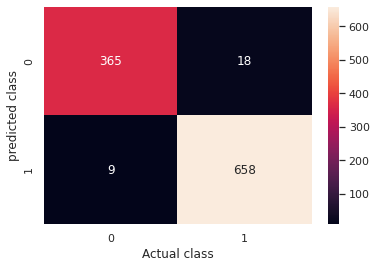

In [16]:
# Libraries:
#  accuracy_score: computes the accuracy classification score.
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import accuracy_score, confusion_matrix

ac = accuracy_score(y_test, clf_knn.predict(x_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, clf_knn.predict(x_test_scaled))

# plotting
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

---
#### Your Turn:

1) Try to plot the decision boundaries for different values of *k* and see if you can find any difference with respect to the previoua plot.



- With k=5 neighbours.


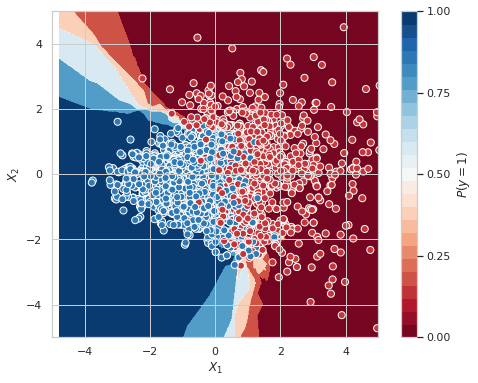

In [17]:
# Answer (repeat that cell with different values of k)
k = 5

print("- With k=%i neighbours."%k)

clf_knn = KNeighborsClassifier(n_neighbors=k) 
clf_knn.fit(x_train_scaled, y_train)

plot_decision_boundary(x_train=x_train_scaled, 
                       y_train=y_train, 
                       estimator=clf_knn)

2) Now check the accuracies. Can you find a value of k that results in a higher accuracy (previous one was 97%)?

Plot the confusion matrix if you wish.

In [18]:
# Answer (one k value)

k = 3

clf_knn = KNeighborsClassifier(n_neighbors=k) 
clf_knn.fit(x_train_scaled, y_train)

ac = accuracy_score(y_test, clf_knn.predict(x_test_scaled))
print('- With k=',k, 'Accuracy is' ,ac)

- With k= 3 Accuracy is 0.9742857142857143


Let's make it automatic for several values of k.

In [19]:
# Answer (for a list of k values)

k_list = [1, 3, 5, 10, 20] # list with k values to test

ac_list = [] # empty list to store accuracy results
for k in k_list:
    clf_knn = KNeighborsClassifier(n_neighbors=k) 
    clf_knn.fit(x_train_scaled, y_train)

    ac = accuracy_score(y_test, clf_knn.predict(x_test_scaled))
    print('- With k=%i, accuracy is %.4f'%(k,ac))
    
    ac_list += [ac] # updating the list with accuracy results

- With k=1, accuracy is 0.9648
- With k=3, accuracy is 0.9743
- With k=5, accuracy is 0.9752
- With k=10, accuracy is 0.9762
- With k=20, accuracy is 0.9638


**Pitfall**: simply plotting the results, without taking care of the y-axis limit, could be potentialy misleading!

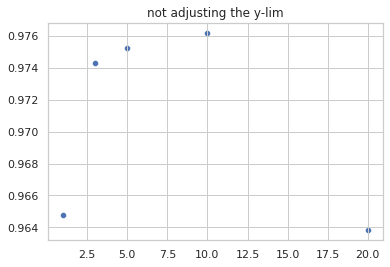

In [20]:
# Plotting (not adjusting the y-lim)

sns.scatterplot(x=k_list, y=ac_list, markers='-o')
plt.title("not adjusting the y-lim");

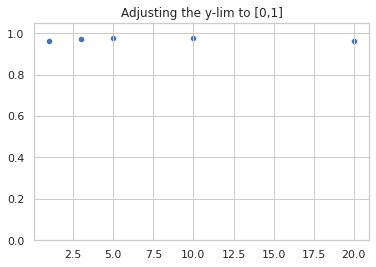

In [21]:
# Plotting, correct perspective

sns.scatterplot(x=k_list, y=ac_list, markers='-o')
plt.title("Adjusting the y-lim to [0,1]");
plt.ylim(0,1.05);

3) The parameter *weights* in K-NN defines the type of method we are going to use. By default, scikit-learn defines the weights as ‘uniform’. However, we can change this parameter to 'distance' to use the algorithm weighted K-NN discussed in our class. Change this parameter to 'distance' and see what happens (plot the decision boundary and print the accuracy). 

tip:
```python
clf_knn_weighted = KNeighborsClassifier(n_neighbors=YOUR K, weights='...')    
```

For more information, K-NN documentation can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

**Answer**

We can use a single run to compare with the *k=5* example:

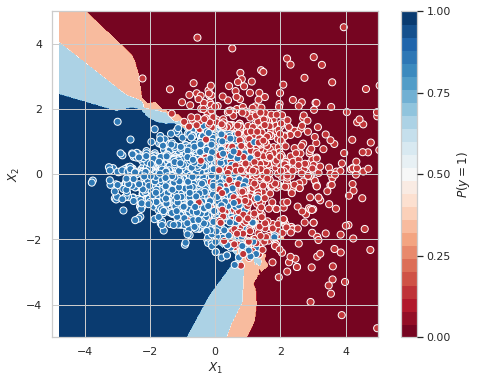

- With k= 3 Accuracy is 0.9742857142857143


In [22]:
# Answer (one k value)

k = 3

clf_knn = KNeighborsClassifier(n_neighbors=k) 
clf_knn.fit(x_train_scaled, y_train)

plot_decision_boundary(x_train=x_train_scaled, 
                       y_train=y_train, 
                       estimator=clf_knn)


ac = accuracy_score(y_test, clf_knn.predict(x_test_scaled))
print('- With k=',k, 'Accuracy is' ,ac)

Or we can use the *k_list* and compare the result with question 2:

In [23]:
# Same answer in question 2, but with another list to store the new results

ac_list_2 = [] # empty list to store accuracy results with weights="distance"

for k in k_list:
    clf_knn = KNeighborsClassifier(n_neighbors=k, weights="distance") 
    clf_knn.fit(x_train_scaled, y_train)

    ac = accuracy_score(y_test, clf_knn.predict(x_test_scaled))
    print('- With k=%i, accuracy is %.4f'%(k,ac))
    
    ac_list_2 += [ac] # updating the list with accuracy results

- With k=1, accuracy is 0.9648
- With k=3, accuracy is 0.9743
- With k=5, accuracy is 0.9781
- With k=10, accuracy is 0.9743
- With k=20, accuracy is 0.9695


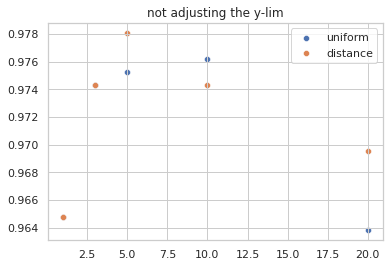

In [24]:
# Plotting (not adjusting the y-lim)

sns.scatterplot(x=k_list, y=ac_list, markers='-o', label="uniform")
sns.scatterplot(x=k_list, y=ac_list_2, markers='-o', label="distance")

plt.title("not adjusting the y-lim");

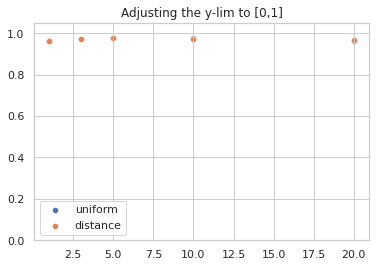

In [25]:
# Plotting, correct perspective

sns.scatterplot(x=k_list, y=ac_list, markers='-o', label="uniform")
sns.scatterplot(x=k_list, y=ac_list_2, markers='-o', label="distance")

plt.title("Adjusting the y-lim to [0,1]");
plt.ylim(0,1.05);

---

### Random Forest
<a id=rdf></a>

The Decition Trees are examples of information-based learning. It seeks for the most informative feature to split the dataset. The Random Forest classifier builds multiple decision trees and merges them together to get a more accurate and stable prediction (less proned to overfit).

<img src="imgs/randomForest.png" alt="Drawing" style="width: 400px;"/>

In [26]:
from sklearn.ensemble import RandomForestClassifier # implements random forest.

clf_rf = RandomForestClassifier(n_estimators=2)  # 2 trees in the forest.    
clf_rf.fit(x_train_scaled,y_train)

RandomForestClassifier(n_estimators=2)

Again, let's have a look at the **decision boundary**. It helps us to get insights about how the classifier is partioning the feature space.

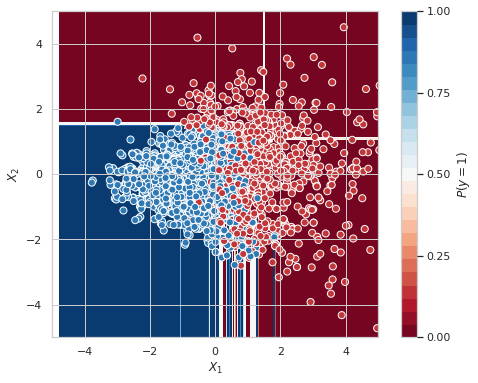

In [27]:
plot_decision_boundary(x_train_scaled, y_train, clf_rf)

Let's now check the **confusion matrix** and compute the **accuracy** of Random Forest.

Accuracy is:  0.9990476190476191


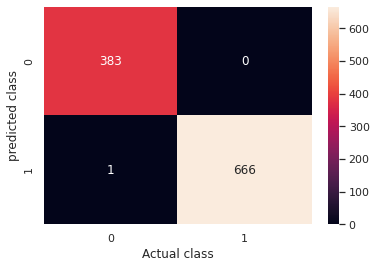

In [28]:
# Libraries:
#  accuracy_score: computes the accuracy classification score.
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import accuracy_score, confusion_matrix # calling the libraries again, just in case 
                                                             # you decided to not run kNN cell

ac = accuracy_score(y_test, clf_rf.predict(x_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test_scaled))

sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

---
#### Your Turn: 

1) Try to plot the decision boundary for different *n_estimators* and see what you find out. There are other hyperparameters of Random Forest and Decision Trees that you can also try, for instance the *max_depth*. Have a look at the Random Forest [documentation](http://scikit-learn.org/stable/modules/ensemble.html) to check how they work.

- Using n_estimators = 50


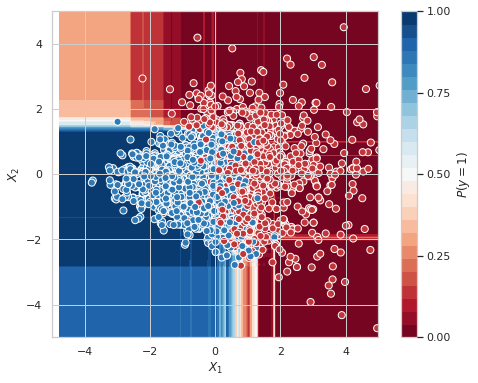

In [29]:
n_estimators = 50

print("- Using n_estimators = %i"%n_estimators)
      
clf_rf = RandomForestClassifier(n_estimators=n_estimators)  # 50 trees in the forest. 

clf_rf.fit(x_train_scaled,y_train)
plot_decision_boundary(x_train_scaled, y_train, clf_rf)

2) How do you compare the performance with the K-NN? Did you find a better combination of hyperparameters?

In [30]:
ac = accuracy_score(y_test, clf_rf.predict(x_test_scaled))
print('Accuracy is: ',ac)

Accuracy is:  0.9990476190476191


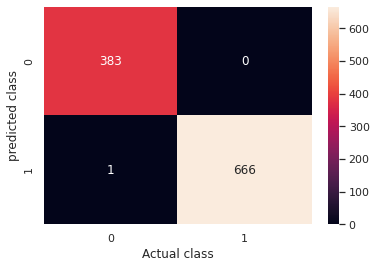

In [31]:
cm = confusion_matrix(y_test,clf_rf.predict(x_test_scaled))

sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

---

### Support Vector Machines
<a id=svm></a>

SVM are powerful discriminative classifiers formally defined by the concept of maximing a separating hyperplane. Given labeled training data, the algorithm outputs an optimal hyperplane which categorizes new examples.

<img src="imgs/svm.png" alt="Drawing" style="width: 400px;"/>


SVM use the kernel trick to project the data to another space by using the **kernel** in order to perform the (linear) classification. Indeed, kernels are the secret source that makes SVMs interesting ML techniques. In this notebook, we are going to explore three different types of kernels:
 - [Linear Kernel](#linear)
 - [Radial Basis Function Kernel](#rbf)
 - [Polynomial Kernel](#poly)



#### Linear Kernel
<a id=linear></a>

The Linear kernel is the simplest kernel function. It is given by the inner product:

$$\mathcal{K}(x,y) = x^Ty$$

In [32]:
from sklearn.svm import SVC # implements the Support Vector Machine

# Important note: 
#   SVC implementation is based on libsvm. The fit time complexity is more than quadratic 
#   with the number of samples which makes it hard to scale to dataset with more than a couple of 
#   10000 samples.
# source: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
#LinearSVC is based on liblinear, offering an optimized implementation for linear SVMs. It does not support the kernel trick,
#but its time complexity scales almost linear w.r.t. the number of instances and features.

# linear svm
# in order to plot the decision boundaries, we MUST set probability = True.
clf_linear = SVC(kernel = 'linear', C=0.01, probability = True)

clf_linear.fit(x_train_scaled, y_train)

SVC(C=0.01, kernel='linear', probability=True)

SVM **decision boundary**. 

__PS: make sure that <font color='blue'>probability</font> was defined as <font color='green'>True</font>. Otherwise, *plot_decision_boundary* will raise an error as we are using *predict_proba*__.

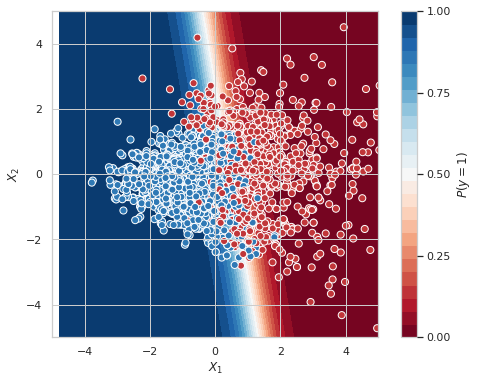

In [33]:
# plot_decision_boundary receives the training set (x_train_scaled), the labels (y_train) and
# the classifier (clf_knn) and plots the decision bounbary by projecting the data to 2 dimension by using 
# PCA (Principal Components Analysis)
plot_decision_boundary(x_train_scaled, y_train, clf_linear)

**Confusion matrix** and **accuracy** for SVM. 

Accuracy is:  0.9085714285714286


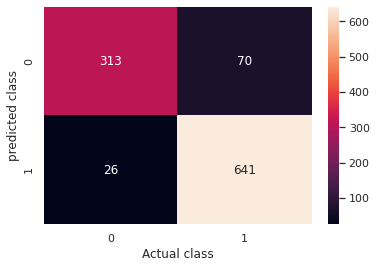

In [34]:
# Libraries:
#  accuracy_score: computes the accuracy classification score.
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import accuracy_score, confusion_matrix # calling the libraries again, just in case 
                                                             # you decided to not run kNN and RDF cells
    
ac = accuracy_score(y_test, clf_linear.predict(x_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, clf_linear.predict(x_test_scaled))

sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

---
#### Your Turn:

1) Try to plot the decision boundary for different values of *C*. 

- With C=5.


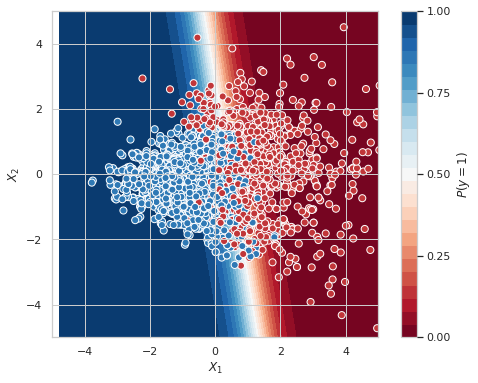

In [35]:
# Answer (repeat that cell with different values of C)
C = 5

print("- With C=%i."%C)

clf_linear = SVC(kernel = 'linear', C=C, probability = True) 
clf_linear.fit(x_train_scaled, y_train)

plot_decision_boundary(x_train=x_train_scaled, 
                       y_train=y_train, 
                       estimator=clf_linear)

2) Compute the accuracy and show if the SVM could outperform Random Forest or K-NN.

In [36]:
# Answer

ac = accuracy_score(y_test, clf_linear.predict(x_test_scaled))
print('Accuracy is: ',ac)

Accuracy is:  0.9247619047619048


**Remark**: you can try to answer question 2 using a list of C values (see the answers for K-NN questions)

---

#### Polynomial Kernel
<a id=poly></a>

The Polynomial kernel are well suited for problems where all the training data is normalized.

$$\mathcal{K}(x,y) = (\gamma x^Ty+r)^d$$

in which $\gamma$ is the slope, $r$ a constant term and the $d$ a polynomial degree.

In [37]:
from sklearn.svm import SVC # implements the Support Vector Machine

# Important note: 
#   SVC implementation is based on libsvm. The fit time complexity is more than quadratic 
#   with the number of samples which makes it hard to scale to dataset with more than a couple of 
#   10000 samples.
# source: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#LinearSVC is based on liblinear, offering an optimized implementation for linear SVMs. It does not support the kernel trick,
#but its time complexity scales almost linear w.r.t. the number of instances and features.

# in order to plot the decision boundaries, we MUST set probability = True.
# coef0 is the constant term r
clf_poly = SVC(kernel = 'poly', C=1.4, gamma=0.005, coef0=1.2, degree=5, probability = True)

clf_poly.fit(x_train_scaled, y_train)

SVC(C=1.4, coef0=1.2, degree=5, gamma=0.005, kernel='poly', probability=True)

**Decision boundary** for the poly kernel. 

__PS: make sure that <font color='blue'>probability</font> was defined as <font color='green'>True</font>. Otherwise, *plot_decision_boundary* will raise an error as we are using *predict_proba*__.

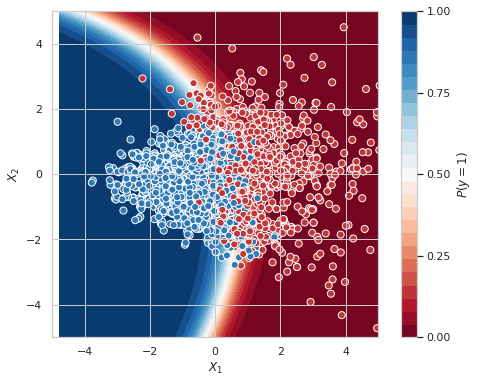

In [38]:
plot_decision_boundary(x_train_scaled, y_train, clf_poly)

**Confusion matrix** and **accuracy** of the poly kernel. 

Accuracy is:  0.939047619047619


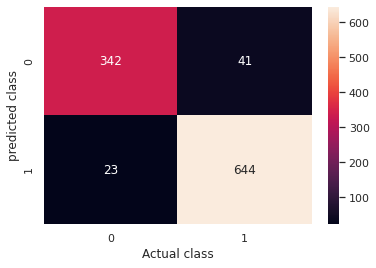

In [39]:
# Libraries:
#  accuracy_score: computes the accuracy classification score.
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import accuracy_score, confusion_matrix # calling the libraries again, just in case 
                                                             # you decided to not run kNN and RF cells
    
ac = accuracy_score(y_test, clf_poly.predict(x_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, clf_poly.predict(x_test_scaled))

sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

---
#### Your Turn:

1) Try to plot the decision boundary or check the accuracy for different _C_, *degree*, *coef0* and *gamma* values. What was the best classifier so far?

In [40]:
C      = 0.1
gamma  = 0.01
coef0  = 1.8
degree = 5

print("- Using:")
print("   C=",C, "\n   gamma=",gamma, "\n   coef0=",coef0, "\n   degree=",degree)
      
clf_poly = SVC(kernel = 'poly', 
                           C=C, gamma=gamma, coef0=coef0, degree=degree, probability = True)

clf_poly.fit(x_train_scaled, y_train)
ac = accuracy_score(y_test, clf_poly.predict(x_test_scaled))
print('Accuracy is: ',ac)

- Using:
   C= 0.1 
   gamma= 0.01 
   coef0= 1.8 
   degree= 5
Accuracy is:  0.940952380952381


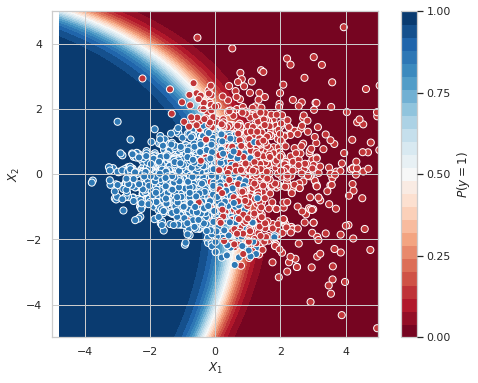

In [41]:
plot_decision_boundary(x_train_scaled, y_train, clf_poly)

---

#### Radial Basis Function Kernel
<a id=rbf></a>

The Radial Basis Function (RBF)  popular kernel function used in SVM and it is given by the following equation:

$$\mathcal{K}(x,y) = \exp(-\gamma\|x-y\|^2)$$
in which $\gamma=\frac{1}{2\sigma^2}$. Note that $sigma$ plays an important role here and should be carefully tuned to the problem. 

In [42]:
from sklearn.svm import SVC # implements the Support Vector Machine

# Important note: 
#   SVC implementation is based on libsvm. The fit time complexity is more than quadratic 
#   with the number of samples which makes it hard to scale to dataset with more than a couple of 
#   10000 samples.
# source: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#LinearSVC is based on liblinear, offering an optimized implementation for linear SVMs. It does not support the kernel trick,
#but its time complexity scales almost linear w.r.t. the number of instances and features.

# in order to plot the decision boundaries, we MUST set probability = True.
clf_rbf = SVC(kernel = 'rbf', C=0.01, gamma=0.1, probability = True)

clf_rbf.fit(x_train_scaled, y_train)

SVC(C=0.01, gamma=0.1, probability=True)

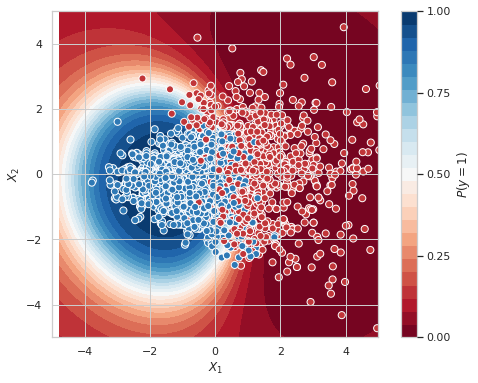

In [43]:
# plotting takes time!
plot_decision_boundary(x_train_scaled, y_train, clf_rbf)

Accuracy is:  0.9038095238095238


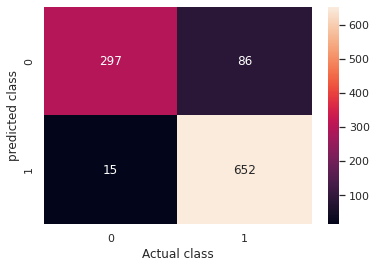

In [44]:
# Libraries:
#  accuracy_score: computes the accuracy classification score.
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import accuracy_score, confusion_matrix # calling the libraries again, just in case 
                                                             # you decided to not run kNN and RF cells
    
ac = accuracy_score(y_test, clf_rbf.predict(x_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, clf_rbf.predict(x_test_scaled))

sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

---
#### Your Turn:

1) Try to plot the decision boundary for different *C* and *gamma* values.

- Using:
   C= 1 
   gamma= 0.01


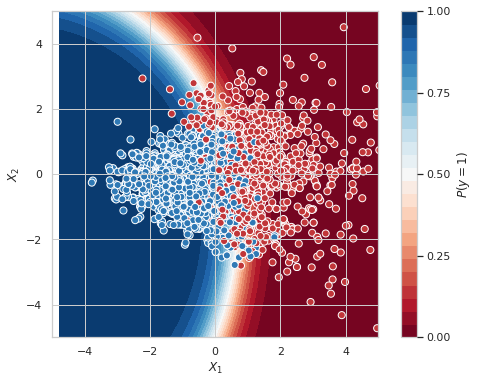

In [45]:
C     = 1
gamma = 0.01

print("- Using:")
print("   C=",C, "\n   gamma=",gamma)
      
clf_rbf = SVC(kernel = 'rbf', C=C, gamma=gamma, probability = True)

clf_rbf.fit(x_train_scaled, y_train)
plot_decision_boundary(x_train_scaled, y_train, clf_rbf)

2) Check the accuracies.

Plot the confusion matrix if you wish.

In [46]:
ac = accuracy_score(y_test, clf_rbf.predict(x_test_scaled))
print('Accuracy is: ',ac)


Accuracy is:  0.9333333333333333


---